# Causal Inference and Predictive Modeling of Housing Prices  
### *A Comparative Study Using 2SLS, Linear Regression, and Neural Networks*

> Exploring both structural relationships and predictive performance across econometric and machine learning methods.


## Introduction

Understanding the dynamics behind housing prices is essential for policymakers, investors, and economists alike.  
This study explores both the **causal relationships** and **predictive performance** of various factors affecting housing prices in Canada from **1988 to 2020**.

Using a **two-stage least squares (2SLS)** approach, I first investigate how **interest rates influence credit volume**, and in turn, how **credit affects housing prices**.

Beyond causal analysis, I compare traditional **linear regression** and **neural network models** to evaluate how well these methods can forecast housing prices.

By combining **econometric techniques** with **machine learning**, this research aims to bridge the gap between **interpretation** and **prediction**, providing a more complete picture of what drives changes in the housing market.


### 1. Import library

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from linearmodels.iv import IV2SLS
import statsmodels.api as sm

In [24]:
CPI_D = pd.read_csv('CPI.csv',encoding='utf-8-sig')
HOUSE_INDEX = pd.read_csv('houseindex.csv',encoding='utf-8-sig')
MORTAGECREDIT = pd.read_csv('mortgagecredit.csv',encoding='utf-8-sig')
MORTAGERATE = pd.read_csv('mortgagerate.csv',encoding='utf-8-sig')
NEW_HOME_SALES = pd.read_csv('newhomes.csv',encoding='utf-8-sig')
NEW_CONDOS = pd.read_csv('newcondos.csv',encoding='utf-8-sig')
UNEMPLOYED = pd.read_csv('unemplyed.csv',encoding='utf-8-sig')


In [25]:
df = pd.merge(CPI_D, HOUSE_INDEX, on='REF_DATE', how='outer')  
df = pd.merge(df, MORTAGECREDIT, on='REF_DATE', how='outer') 
df = pd.merge(df, MORTAGERATE, on='REF_DATE', how='outer')  
df = pd.merge(df, NEW_HOME_SALES, on='REF_DATE', how='outer')  
df = pd.merge(df, NEW_CONDOS, on='REF_DATE', how='outer') 
df = pd.merge(df, UNEMPLOYED, on='REF_DATE', how='outer')
df['REF_DATE'] = pd.to_datetime(df['REF_DATE']) 
df['TimeTrend'] = np.arange(1, len(df) + 1)
df = df.dropna()  
df['TimeTrend'] = df['TimeTrend'] - 444
df['CREDIT'] = df['CREDIT'] / 10000 #Now the unit is 10 billion CAD
df

,REF_DATE,CPI,HINDEX,CREDIT,MRATE,HNUM,CNUM,URATE,TimeTrend
444,1988-11-01,72.3,55.0,19.2308,11.78,8318.0,3844.0,10.2,1
445,1988-12-01,72.3,55.8,19.4579,12.13,7249.0,2670.0,9.8,2
446,1989-01-01,72.7,56.3,19.6837,12.24,5990.0,4667.0,11.3,3
447,1989-02-01,73.2,57.7,19.9273,12.23,5024.0,2137.0,11.1,4
448,1989-03-01,73.6,58.6,20.1617,12.41,6423.0,3310.0,11.0,5
...,...,...,...,...,...,...,...,...,...
818,2020-01-01,136.8,103.4,164.0113,4.08,4000.0,2806.0,8.8,375
819,2020-02-01,137.4,103.8,164.4740,4.08,4302.0,4021.0,8.9,376
820,2020-03-01,136.6,104.1,165.2870,3.90,4655.0,4196.0,15.1,377
821,2020-04-01,135.7,104.1,166.2719,3.95,3603.0,5444.0,22.6,378


| Variable    | Description                          |
|-------------|--------------------------------------|
| REF_DATE    | Observation date (YYYY-MM-DD)        |
| CPI         | Consumer Price Index (inflation)     |
| HINDEX      | Housing market index (target)        |
| CREDIT      | Total housing credit available       |
| MRATE       | Mortgage interest rate (%)           |
| HNUM        | Number of new homes                  |
| CNUM        | Number of new condos                 |
| URATE       | Unemployment rate (%)                |
| TimeTrend   | Monthly counter (1 = Nov 1988)       |

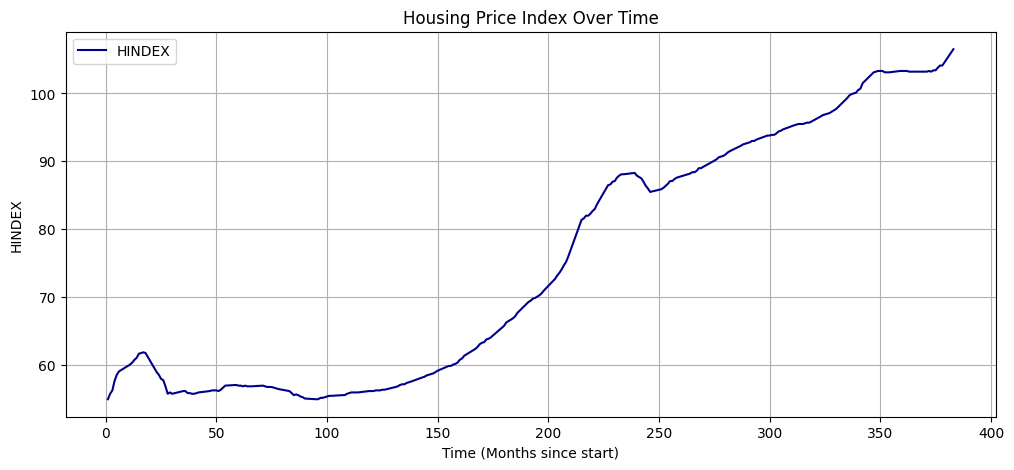

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df["TimeTrend"], df["HINDEX"], label="HINDEX", color="darkblue")
plt.title("Housing Price Index Over Time")
plt.xlabel("Time (Months since start)")
plt.ylabel("HINDEX")
plt.grid(True)
plt.legend()
plt.show()


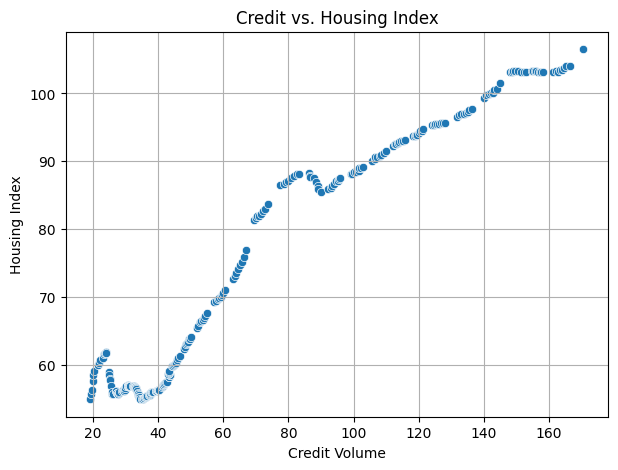

In [42]:
import seaborn as sns

plt.figure(figsize=(7, 5))
sns.scatterplot(x="CREDIT", y="HINDEX", data=df)
plt.title("Credit vs. Housing Index")
plt.xlabel("Credit Volume")
plt.ylabel("Housing Index")
plt.grid(True)
plt.show()


## Interpreting the Credit vs. Housing Price Scatterplot

The scatterplot shows a clear **non-linear relationship** between credit volume and the housing index.  
One possible explanation lies in the **different response speeds** of these two variables.

Housing prices tend to react quickly to shifts in **market sentiment** and **expectations**.  
In contrast, **credit volume**—particularly mortgage lending—adjusts more **slowly**, largely because it’s built on existing stock.  
Most outstanding mortgages don’t change overnight, and new lending is constrained by **approval processes**, **bank risk management**, and **regulatory conditions**.

---

In the **lower range of credit volume**, we already see significant jumps in housing prices.  
This suggests that prices were **responding rapidly** to changing market conditions—perhaps  a **surge in demand**—while the credit stock had not yet caught up.

Later, as credit volume **gradually rises**, the housing index continues to increase but at a **slower pace**.  
That likely reflects the **delayed expansion of credit** following earlier price shifts, as the financial system slowly channels more funds into the housing market.

---

**Conclusion:**  
The shape of the graph supports the idea that **prices move fast, while credit moves slow**—a dynamic consistent with the **structural inertia** of lending systems.


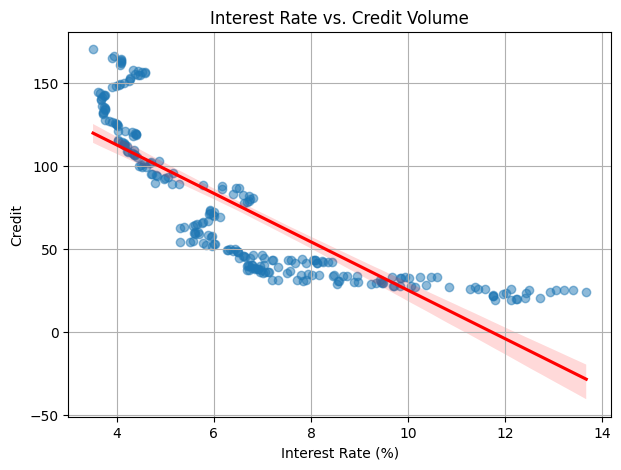

In [28]:
plt.figure(figsize=(7, 5))
sns.regplot(x="MRATE", y="CREDIT", data=df, scatter_kws={"alpha": 0.5},line_kws={"color": "red"})
plt.title("Interest Rate vs. Credit Volume")
plt.xlabel("Interest Rate (%)")
plt.ylabel("Credit")
plt.grid(True)
plt.show()


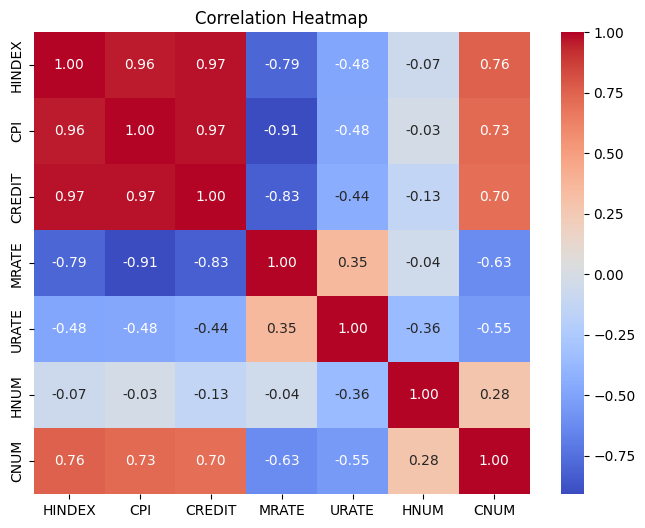

In [29]:
plt.figure(figsize=(8, 6))
corr = df[["HINDEX", "CPI", "CREDIT", "MRATE", "URATE", "HNUM", "CNUM"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


## Use interest rate as an instrument to predict housing price via credit (Two-Stage Least Squares)

---

### First Stage  
Use the instrument (interest rate) to predict the endogenous variable (credit):

$$
\text{CREDIT}_t = \alpha_0 + \alpha_1 \cdot \text{MRATE}_t + \alpha_2 \cdot \text{Controls}_t + \alpha_3 \cdot \text{TimeTrend}_t + u_t
$$

- **Endogenous variable**: `CREDIT`
- **Instrumental variable**: `MRATE` (interest rate)
- **Control variables**: e.g., `URATE`, `HNUM`, `CPI`, `CNUM`, etc.
- **Time trend**: added to account for structural shifts over time

---

### Second Stage  
Use the predicted credit from stage one to estimate the housing price index:

$$
\text{HINDEX}_t = \beta_0 + \beta_1 \cdot \hat{\text{CREDIT}}_t + \beta_2 \cdot \text{Controls}_t + \beta_3 \cdot \text{TimeTrend}_t + \varepsilon_t
$$

- **Dependent variable (Y)**: `HINDEX` (housing price index)
- **$\hat{\text{CREDIT}}$**: fitted values from the first stage regression

---




### Causal Impact of Credit Volume on Housing Prices

To explore the causal impact of credit volume on housing prices, this study adopts the **Two-Stage Least Squares (2SLS)** approach. The motivation for using this method is due to the likely **endogeneity** of credit volume (CREDIT) in the housing price equation. This means that credit volume might be influenced by unobserved factors that also affect housing prices. These factors could include:

- Macroeconomic shocks
- Measurement errors
- Reverse causality (e.g., rising housing prices encouraging more lending)

Because of this endogeneity, using **Ordinary Least Squares (OLS)** could lead to **biased or inconsistent estimates**. To address this issue, we use the **market interest rate (MRATE)** as an instrumental variable for CREDIT.

### Why MRATE is a good instrument for CREDIT:

1. **Relevance**: Interest rates are closely related to credit volume. As interest rates increase, borrowing becomes more expensive, which generally reduces the overall volume of credit in the economy.
  
2. **Exogeneity**: Interest rates, particularly those set through monetary policy, are largely **exogenous** to local housing prices. They affect housing indirectly through credit conditions, not directly. Therefore, MRATE meets the **exclusion restriction** — it impacts housing prices only through its effect on credit.

By using MRATE as an instrument, we can obtain more accurate estimates of the causal effect of credit volume on housing prices.


In [30]:
controls = ['URATE', 'HNUM', 'CPI', 'TimeTrend', 'CNUM']
Y = 'HINDEX'
endog = 'CREDIT'
instrument = 'MRATE'
control_vars = '+'.join(controls)
formula = f"{Y} ~ 1 + [{endog} ~ {instrument}] + {control_vars}"
iv_model = IV2SLS.from_formula(formula, data=df).fit(cov_type='robust')
print(iv_model.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                 HINDEX   R-squared:                      0.9576
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9565
No. Observations:                 255   F-statistic:                    7545.2
Date:                Thu, May 08 2025   P-value (F-stat)                0.0000
Time:                        16:20:17   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1.1349     12.821     0.0885     0.9295     -23.993      26.263
URATE         -0.4768     0.1580    -3.0181     0.00

In [31]:
print(iv_model.first_stage)


    First Stage Estimation Results    
                                CREDIT
--------------------------------------
R-squared                       0.9727
Partial R-squared               0.3482
Shea's R-squared                0.3482
Partial F-statistic             110.91
P-value (Partial F-stat)        0.0000
Partial F-stat Distn           chi2(1)
========================== ===========
Intercept                      -198.94
                             (-6.6472)
URATE                           1.2488
                              (3.4831)
HNUM                           -0.0017
                             (-5.9164)
CPI                             1.6349
                              (3.4902)
TimeTrend                       0.2628
                              (3.1357)
CNUM                            0.0008
                              (1.4898)
MRATE                           6.5316
                              (10.531)
--------------------------------------

T-stats reported in pare

### Linear regression prediction

In [32]:
from sklearn import (           
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [33]:
df2 = df.copy()
X = df2[['CPI', 'CREDIT','MRATE','HNUM','CNUM','URATE','TimeTrend']].values
y = df2['HINDEX'].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25,random_state=42)


In [34]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R-squared:", model.score(X_test, y_test))
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
baseline_mse = np.mean((y_test - np.mean(y_train))**2)
print("Baseline MSE:", baseline_mse)

Coefficients: [ 1.01109596e+00  2.13420226e-01  1.52170664e+00 -7.31127585e-05
  8.74180623e-04 -1.76379049e-01 -7.45021653e-02]
Intercept: -44.214099403753224
R-squared: 0.97244554791382
MSE: 8.66929553892069
Baseline MSE: 316.48691815602643


In [35]:
cv_model = LinearRegression()
cv_scores =cross_val_score(cv_model, X, y, cv=10, scoring='neg_mean_squared_error')
cv_mse_scores = -cv_scores  
print("Cross-validated MSE scores:", cv_mse_scores)
print("Mean CV MSE:", -np.mean(cv_scores))


Cross-validated MSE scores: [142.17987262   3.88483711   6.20210809  37.39519362  17.13205177
  29.97028285  46.54120725   5.11983681   2.86527796  91.3173269 ]
Mean CV MSE: 38.260799498974954


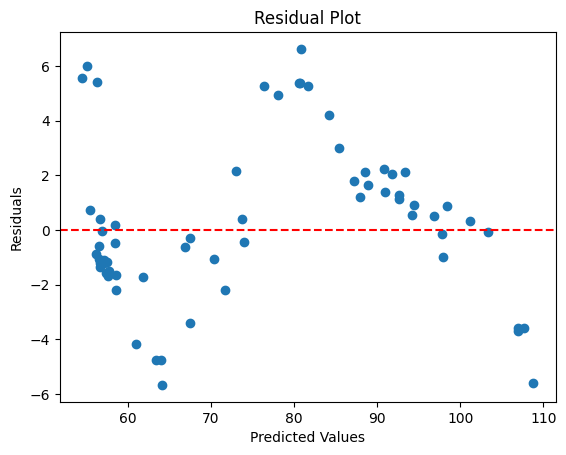

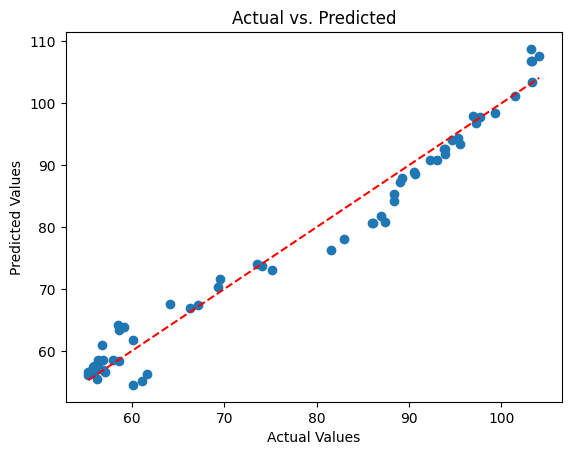

In [36]:
import matplotlib.pyplot as plt

# 1. Residual Plot
plt.scatter(y_pred, y_test - y_pred)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.show()

# 2. Actual vs. Predicted
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title("Actual vs. Predicted")
plt.show()

In [37]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train a neural network model
mlp = MLPRegressor(hidden_layer_sizes=(32, 16), max_iter=10000, random_state=42)
mlp.fit(X_train_scaled, y_train)

# predict on the test set
y_pred = mlp.predict(X_test_scaled)

# calculate the mean squared error
model_mse = mean_squared_error(y_test, y_pred)
print("Model MSE:", model_mse)

# baseline MSE
baseline_pred = np.full_like(y_test, np.mean(y_train), dtype=float)
baseline_mse = mean_squared_error(y_test, baseline_pred)
print("Baseline MSE:", baseline_mse)

# compare model MSE with baseline MSE
improvement = baseline_mse - model_mse
print("Improvement over baseline:", improvement)

Model MSE: 1.4476089590342163
Baseline MSE: 316.48691815602643
Improvement over baseline: 315.03930919699224


In [40]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(32, 16),
        max_iter=10000,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=1000,
        random_state=42
    ))
])

# cross-validation, 10-fold, negative MSE
cv_scores = cross_val_score(pipeline, X, y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# output
print("Cross-Validation MSE:", -cv_scores)
print("Mean CV MSE:", -np.mean(cv_scores))  # 取负得到正 MSE
print("Standard Deviation of CV MSE:", np.std(cv_scores))

Cross-Validation MSE: [  8.17913462   3.35773676   0.26161634   1.54597245   3.61322296
  13.09195563   3.89623995   0.46789698   1.02959611 122.93822652]
Mean CV MSE: 15.838159832838096
Standard Deviation of CV MSE: 35.89830072317522


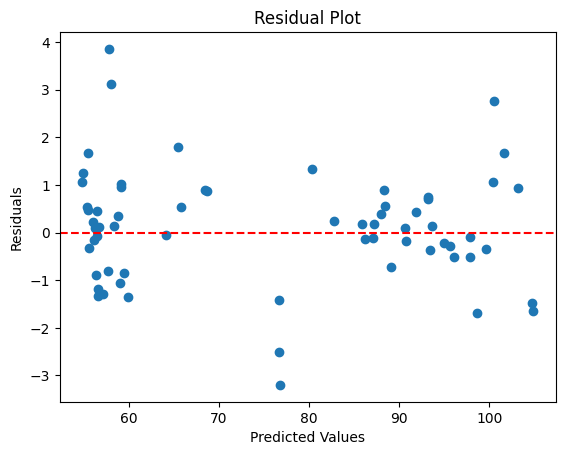

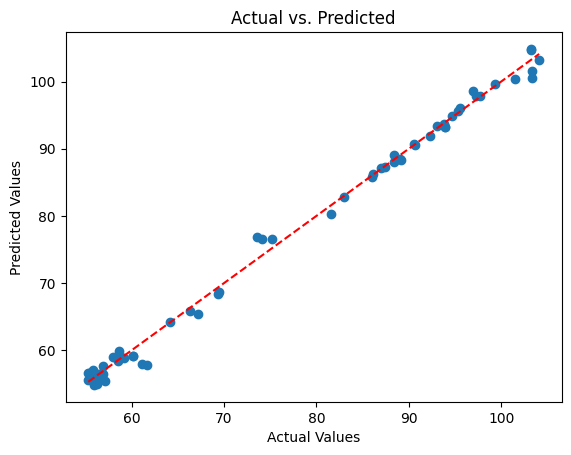

In [ ]:
# 1. Residual Plot
plt.scatter(y_pred, y_test - y_pred)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.show()

# 2. Actual vs. Predicted
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title("Actual vs. Predicted")
plt.show()